In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import splitfolders
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
%cd /Users/irfanmasudi/ANNDL/Challenge/

/Users/irfanmasudi/ANNDL/Challenge


In [4]:
# Dataset folders 
dataset_dir = 'datasets'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
#test_dir = os.path.join(dataset_dir, 'test')

In [5]:
# Plot example images from dataset
labels = ['Apple',       # 0
          'Blueberry',   # 1
          'Cherry',      # 2
          'Corn',        # 3
          'Grape',       # 4
          'Orange',      # 5
          'Peach',       # 6
          'Pepper',      # 7
          'Potato',      # 8
          'Raspberry',   # 9
          'Soybean',     # 10
          'Squash',      # 11
          'Strawberry',  # 12
          'Tomato']      # 13
"""
num_row = 7
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(num_row,8*num_col))
for i in range(num_row*num_col):
    if i < 14:
        class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
"""
#plt.tight_layout()
#plt.show()

"\nnum_row = 7\nnum_col = 2\nfig, axes = plt.subplots(num_row, num_col, figsize=(num_row,8*num_col))\nfor i in range(num_row*num_col):\n    if i < 14:\n        class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]\n        class_img = class_imgs[0]\n        img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))\n        ax = axes[i//num_col, i%num_col]\n        ax.imshow(np.array(img))\n        ax.set_title('{}'.format(labels[i]))\n"

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rotation_range=40,
                                    height_shift_range=60,
                                    width_shift_range=60,
                                    zoom_range=0.5,
                                    horizontal_flip=True,
                                    vertical_flip=True, 
                                    fill_mode='reflect',
                                    rescale=1/255.)

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(299,299),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False,
                                               seed=seed)

Found 15062 images belonging to 14 classes.
Found 2666 images belonging to 14 classes.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Creating an instance of ImageDataGenerator without Data Augmentation
noaug_train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.inception_resnet_v2.preprocess_input)
valid_data_gen       = ImageDataGenerator(preprocessing_function=tfk.applications.inception_resnet_v2.preprocess_input)

train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(299,299),
                                                           color_mode='rgb',
                                                           classes=None,
                                                           class_mode='categorical',
                                                           batch_size=64,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(299,299),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False, # no need to shuffle validation set
                                               seed=seed)

Found 67279 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [7]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))
    plt.show()
    
    return batch

(Input) image shape: (64, 299, 299, 3)
Target shape: (64, 14)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Apple


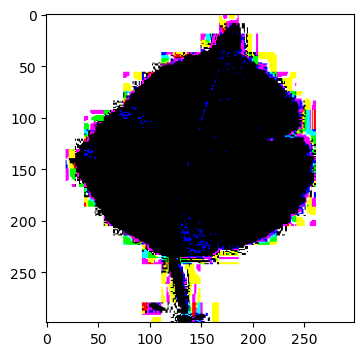

In [8]:
# Get a sample from dataset and show info
_ = get_next_batch(valid_gen)

In [13]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_gen.classes),
                                     y = train_gen.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))
class_weights

{0: 1.282308871105057,
 1: 2.716810966810967,
 2: 2.1734487734487735,
 3: 1.049616724738676,
 4: 0.8683269918136747,
 5: 0.7244829244829245,
 6: 1.2962134251290878,
 7: 1.6551648351648351,
 8: 1.769501879699248,
 9: 4.802933673469388,
 10: 0.7835813130787639,
 11: 2.2091522440598417,
 12: 1.8808691308691308,
 13: 0.22233046969562778}

In [14]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


In [11]:
input_shape = (256, 256, 1)
epochs = 200

In [12]:
METRICS = [
      tfk.metrics.TruePositives(name='tp'),
      tfk.metrics.FalsePositives(name='fp'),
      tfk.metrics.TrueNegatives(name='tn'),
      tfk.metrics.FalseNegatives(name='fn'), 
      tfk.metrics.BinaryAccuracy(name='accuracy'),
      tfk.metrics.Precision(name='precision'),
      tfk.metrics.Recall(name='recall'),
      tfk.metrics.AUC(name='auc'),
]

In [13]:
# Model used for the exercise:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    batchNorm1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(batchNorm1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    batchNorm2 = tfkl.BatchNormalization()(conv2)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(batchNorm2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    batchNorm3 = tfkl.BatchNormalization()(conv3)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(batchNorm3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    batchNorm4 = tfkl.BatchNormalization()(conv4)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(batchNorm4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    batchNorm5 = tfkl.BatchNormalization()(conv5)
    
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalAvglPooling')(batchNorm5)
    glob_pooling = tfkl.Dropout(0.3, seed=seed, name='GAPDropout')(glob_pooling)

    batchNorm6 = tfkl.BatchNormalization()(glob_pooling)
    
    classifier_layer = tfkl.Dense(
        units=256,  
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Classifier')(batchNorm6)
    classifier_layer = tfkl.Dropout(0.3, seed=seed, name='ClassifierDropout')(classifier_layer)

    output_layer = tfkl.Dense(
        units=14, 
        activation='softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model_GAP')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=METRICS)

    # Return the model
    return model

In [14]:
model = build_model(input_shape)
#model.summary()
#visualkeras.layered_view(model, legend=True, spacing=10, scale_xy=1)

In [26]:
del model

In [27]:
model = tfk.models.load_model('logs/incresnet/incresnet_Nov22_22-16-08/ckpts/cp.ckpt')

In [28]:
predictions = model.predict(valid_gen)
y_pred = np.argmax(predictions, axis=1)
#print('Confusion Matrix')
#print(confusion_matrix(valid_gen.classes, y_pred))

In [29]:
#Defining function for confusion matrix plot
y_true = valid_gen.classes
classes = labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):


    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Accuracy: 0.9623
Precision: 0.9491
Recall: 0.9785
F1: 0.9624
Normalized confusion matrix


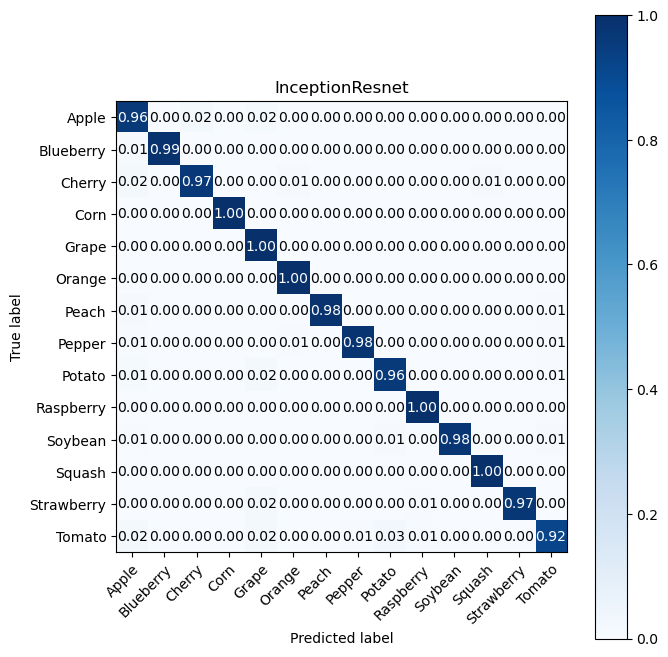

In [30]:
#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))


plot_confusion_matrix(y_true, y_pred, classes=labels, normalize = True,
                      title='InceptionResnet')
plt.savefig('InceptionResnet.png')
plt.show()

In [49]:
predictions = model.predict(valid_gen)
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[130   3   3   1   0   0   1   3   0   1   6   1   0   0]
 [  0  71   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  83   1   2   0   0   1   0   0   1   0   0   0]
 [  0   0   0 181   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   1 210   0   0   0   1   0   0   3   1   0]
 [  0   1   5   3   0 247   4   3   0   0   0   0   0   0]
 [  1   0   1   1   0   0 143   1   0   0   0   0   0   0]
 [  1   0   0   3   1   1   1 104   0   0   1   0   2   1]
 [  2   0   0   0   2   0   0   0  96   0   1   1   4   2]
 [  0   0   0   0   0   0   0   0   0  40   0   0   0   0]
 [  2   0   0   0   0   0   0   1   1   0 239   0   0   0]
 [  1   0   0   2   0   0   0   0   0   0   1  83   0   0]
 [  1   1   0   1   0   0   0   0   0   1   0   0  97   0]
 [ 36   5   7   9  25   4   3  48  24   3   6  10  19 655]]


Accuracy: 0.913
Precision: 0.8754
Recall: 0.9517
F1: 0.9081


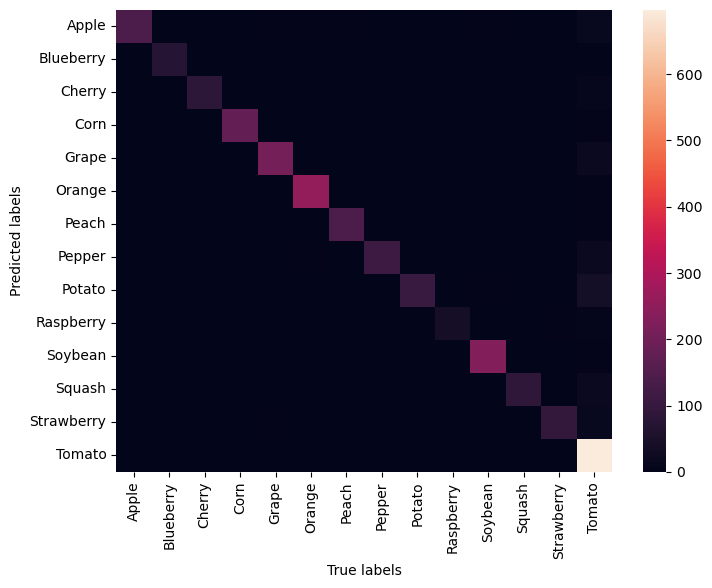

In [60]:
# Compute the confusion matrix
cm = confusion_matrix(valid_gen.classes, np.argmax(predictions, axis=-1))

#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.T, xticklabels=list(valid_gen.class_indices), yticklabels=list(valid_gen.class_indices))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tta_steps = 5
preds_tta = []
for i in range(tta_steps):
    aug_test_data_gen = ImageDataGenerator(rotation_range=30,
                                           height_shift_range=50,
                                           width_shift_range=50,
                                           zoom_range=0.3,
                                           horizontal_flip=True,
                                           vertical_flip=True, 
                                           fill_mode='reflect',
                                           rescale=1/255.)
    
    gen = ImageDataGenerator(fill_mode='constant', cval=0.)

    newX = gen.apply_transform(X, aug_test_data_gen)
    preds = model.predict(newX)
    #print('Before ', preds.shape)
    preds_tta.append(preds)
    #print(i,  len(preds_tta))
final_pred = np.mean(preds_tta, axis=0)

NameError: name 'X' is not defined

In [49]:
tta_steps = 5
preds_tta = []
for i in tqdm(range(tta_steps)):
    preds = model.predict(valid_gen)
    #     print('Before ', preds.shape)
    preds_tta.append(preds)
    #     print(i,  len(preds_tta))

100%|██████████| 5/5 [01:02<00:00, 12.56s/it]


In [25]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
final_pred.shape

(1779, 14)

In [27]:
# Predict the test set with the CNN
predictions = model.predict(valid_gen)
predictions.shape

(1779, 14)

In [53]:
# Compute the confusion matrix
cm = confusion_matrix(valid_gen.classes, np.argmax(final_pred, axis=-1))

#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(final_pred, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(final_pred, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(final_pred, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(final_pred, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.T, xticklabels=list(valid_gen.class_indices), yticklabels=list(valid_gen.class_indices))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'final_pred' is not defined

Accuracy: 0.9567
Precision: 0.9522
Recall: 0.9469
F1: 0.9489


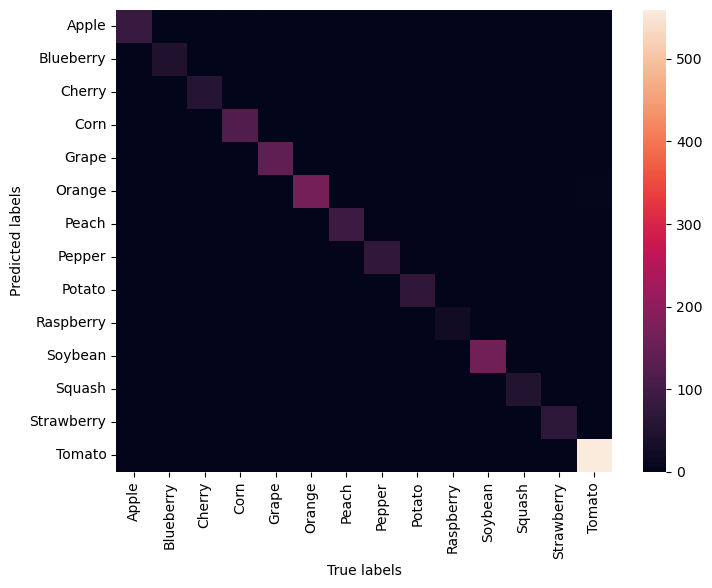

In [31]:
# Compute the confusion matrix
cm = confusion_matrix(valid_gen.classes, np.argmax(predictions, axis=-1))

#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.T, xticklabels=list(valid_gen.class_indices), yticklabels=list(valid_gen.class_indices))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [15]:
%cd /Users/irfanmasudi/ANNDL/Challenge/datasets/train

/Users/irfanmasudi/ANNDL/Challenge/datasets/train


In [16]:
sample = []
for label in labels:
    count = 0
    dir = label
    for path in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, path)):
            count += 1
    sample.append([label,count])
sample = pd.DataFrame(sample)
sample.columns=['class','count']
sample

,class,count
0,Apple,889
1,Blueberry,420
2,Cherry,524
3,Corn,1085
4,Grape,1312
5,Orange,1573
6,Peach,879
7,Pepper,688
8,Potato,644
9,Raspberry,237


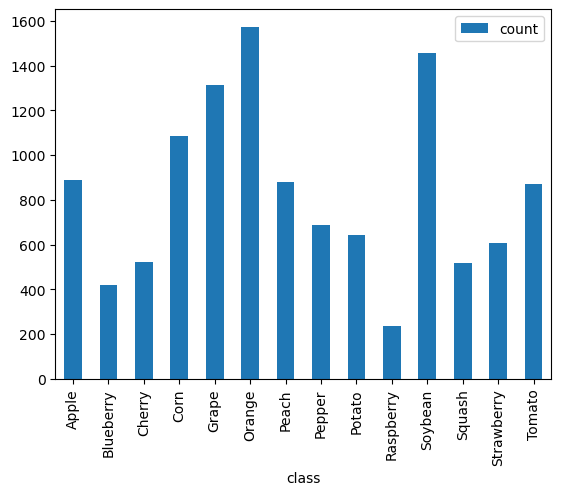

In [17]:
sample.plot(x='class', kind='bar')
plt.show()

In [32]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[ 83   1   1   0   2   1   0   3   0   0   2   1   1   4]
 [  0  46   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  56   0   0   0   0   1   0   0   1   0   0   1]
 [  3   0   0 116   0   0   0   0   0   0   0   1   0   1]
 [  0   0   2   0 138   0   0   0   1   0   0   1   1   3]
 [  0   1   2   0   0 168   0   0   0   0   1   0   0   3]
 [  1   1   0   0   0   0  89   4   0   0   0   0   0   3]
 [  1   0   0   0   0   1   0  73   0   0   1   0   0   1]
 [  0   0   0   0   0   0   0   0  70   0   1   0   0   1]
 [  0   0   0   0   0   0   0   0   0  26   0   0   1   0]
 [  1   0   0   0   0   0   0   0   0   0 160   0   0   1]
 [  1   0   0   2   0   0   0   0   0   0   0  52   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66   2]
 [  0   1   0   0   0   5   1   3   1   0   0   0   0 559]]


In [ ]:
y_pred = np.argmax(final_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[ 90   0   2   0   1   0   0   3   0   0   0   1   0   2]
 [  0  47   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  57   0   0   0   0   0   0   0   1   0   0   1]
 [  1   1   0 119   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 141   0   0   0   1   0   0   1   2   1]
 [  0   1   0   0   0 173   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0  94   1   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0  73   0   0   2   0   0   2]
 [  0   0   0   0   0   0   0   0  68   0   3   0   0   1]
 [  0   0   0   0   0   0   0   0   0  27   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0 160   0   0   1]
 [  0   0   0   2   1   0   0   0   0   0   0  52   0   3]
 [  0   0   0   0   1   0   0   0   0   0   0   0  66   1]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0 569]]
